# Assignment 2 Task 2
* GradCAM and Occlusion

# Setup


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from captum.attr import LayerGradCam, Occlusion
from captum.attr import visualization as viz
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder


class SimpleCNN(nn.Module):
    # Constructor
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Convolutional Blocks (Conv -> ReLU -> Pool)
        # Block 1
        self.conv1 = nn.Conv2d(
            in_channels=3,  # 3 for RGB images
            out_channels=16,  # 16 filters
            kernel_size=3,  # 3x3 filter
            padding=1,
        )  # Keeps image size the same
        self.bn1 = nn.BatchNorm2d(num_features=16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Downsamples by 2

        # Dropout to prevent overfitting
        self.dropout1 = nn.Dropout2d(p=0.2)

        # Block 2
        self.conv2 = nn.Conv2d(
            in_channels=16,  # Must match out_channels of conv1
            out_channels=32,
            kernel_size=3,
            padding=1,
        )
        self.bn2 = nn.BatchNorm2d(num_features=32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout2 = nn.Dropout2d(p=0.2)

        self.conv3 = nn.Conv2d(
            in_channels=32,  # Must match out_channels of conv1
            out_channels=64,
            kernel_size=3,
            padding=1,
        )
        self.bn3 = nn.BatchNorm2d(num_features=64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout2d(p=0.2)

        # --- Define the Classifier "Head" ---
        # This part flattens the 3D feature map to a 1D vector
        # Example calculation for 224x224 images:
        # 224 -> pool1 -> 112 -> pool2 -> 56 -> pool3 -> 28
        # So the flattened size will be: 64 (channels) * 28 (height) * 28 (width)
        # use nn.Flatten() to do this automatically

        self.flatten = nn.Flatten()

        # 64 channels * 28 H * 28 W = 50,176

        self.fc1 = nn.Linear(in_features=64 * 28 * 28, out_features=128)
        self.relu3 = nn.ReLU()

        self.dropoutfc1 = nn.Dropout(p=0.5)

        # 1 neuron for binary classification (cat vs. dog)
        self.fc2 = nn.Linear(in_features=128, out_features=1)

    # Forward Pass
    def forward(self, x):
        # 'x' is the input batch of images
        # Shape: [batch_size, 3, 224, 224]

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        # Shape is [batch_size, 16, 112, 112]

        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        # Shape is [batch_size, 32, 56, 56]

        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        # Shape is [batch_size, 64, 28, 28]

        x = self.dropout3(x)

        x = self.flatten(x)
        # Shape is [batch_size, 50,176]

        x = self.fc1(x)
        x = self.relu3(x)
        # Shape is [batch_size, 128]

        x = self.dropoutfc1(x)

        x = self.fc2(x)
        # Shape is [batch_size, 1]

        return x

In [ ]:
IMG_SIZE = 224
val_test_transforms = transforms.Compose([
    transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    # Use the *exact* mean/std you used for training
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Define  test directory
test_dir = '/workspaces/eng-ai-agents/assignments/assignment-2/data/test' # <--- SET THIS PATH

test_dataset = ImageFolder(root=test_dir, 
                           transform=val_test_transforms)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=32, # Batch size doesn't matter much here
                         shuffle=False) # No need to shuffle


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a new, un-trained instance of the model
model = SimpleCNN().to(device)

# Load saved weights
model.load_state_dict(torch.load("best_model_72.pth")) 

model.eval()

/tmp/ipykernel_9372/237487124.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_71.pth"))


SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.2, inplace=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.2, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout2d(p=0.2, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=

In [4]:
data_iter = iter(test_loader)
images, labels = next(data_iter)

# get first image from batch
img = images[0].unsqueeze(0).to(device)
true_label = labels[0].item()

original_image = img.squeeze(0).cpu().detach().numpy()

print(f"True Label: {'Dog' if true_label == 1 else 'Cat'}")

original_image_np = img.squeeze(0).cpu().detach().numpy()
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
original_image_np = original_image_np.transpose(1, 2, 0)
unnormalized_image = std * original_image_np + mean
original_image_to_plot = np.clip(unnormalized_image, 0, 1)


True Label: Cat


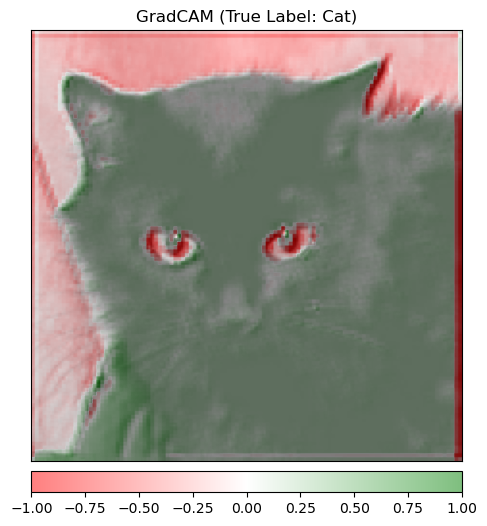

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from captum.attr import LayerAttribution, LayerGradCam
from captum.attr import visualization as viz


layer_gc = LayerGradCam(model, model.conv2) # Or model.bn1

attribution_gc = layer_gc.attribute(img, target=None) 

# Upsample the heatmap to match the image size (224x224)
upsampled_gc = LayerAttribution.interpolate(attribution_gc, img.shape[2:])


attr_to_plot_2d = upsampled_gc.squeeze().cpu().detach().numpy()
attr_to_plot_3d = np.expand_dims(attr_to_plot_2d, axis=-1)

# Pass the 3D heatmap to the visualizer
_ = viz.visualize_image_attr(
    attr = attr_to_plot_3d,  # <-- USE THE 3D ARRAY
    original_image = original_image_to_plot,
    method = "blended_heat_map",
    sign = "all",
    show_colorbar = True,
    title = f"GradCAM (True Label: {'Dog' if true_label == 1 else 'Cat'})"
)

True Label: Cat
Shape of 'original_image_to_plot': (224, 224, 3)
Shape of 'attr_to_plot' (now 3D): (224, 224, 1)
Min/Max of 'attr_to_plot': -0.7975 / 0.4735


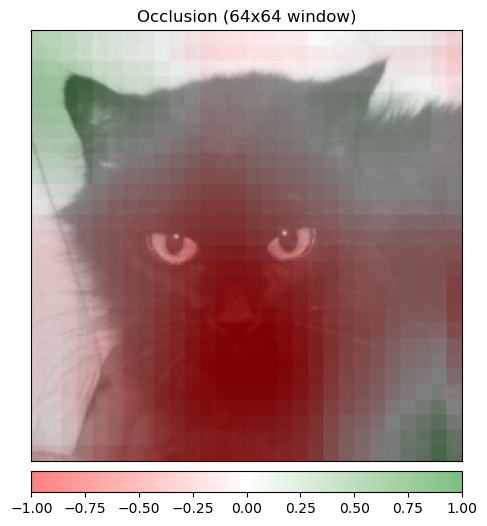

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import Occlusion, LayerAttribution
from captum.attr import visualization as viz

# --- 1. Get a Single Image ---
# (You can re-use 'img', 'original_image_to_plot', and 'true_label'
# from the GradCAM cell if you're in the same notebook)
data_iter = iter(test_loader)
images, labels = next(data_iter)
img = images[0].unsqueeze(0).to(device)
true_label = labels[0].item()
print(f"True Label: {'Dog' if true_label == 1 else 'Cat'}")

# Prepare the 'original_image' for plotting
original_image_np = img.squeeze(0).cpu().detach().numpy()
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
original_image_np = original_image_np.transpose(1, 2, 0)
unnormalized_image = std * original_image_np + mean
original_image_to_plot = np.clip(unnormalized_image, 0, 1)


# --- 2. Prepare the 'attr' (Occlusion Heatmap) ---

# Initialize Occlusion
oc = Occlusion(model)

# Define your "mask" (e.g., a 32x32 pixel square)
window_shape1 = (3, 16, 16) 
window_shape2 = (3, 32, 32) 
window_shape3 = (3, 64, 64) 
window_stride = (3, 8, 8)

# Calculate the attribution (this is the small heatmap)
# We use target=None just like in GradCAM
attribution_occ = oc.attribute(
    img,
    sliding_window_shapes = window_shape3,
    strides = window_stride,
    target = None 
)

# Upsample the heatmap to match the image size (224x224)
upsampled_occ = LayerAttribution.interpolate(attribution_occ, img.shape[2:])

attr_C_H_W = upsampled_occ.squeeze().cpu().detach().numpy()

# 2. Average the 3 channels into one: shape (224, 224)
attr_mean_2d = np.mean(attr_C_H_W, axis=0)

# 3. Add the fake channel for the plotter: shape (224, 224, 1)
attr_to_plot_3d = np.expand_dims(attr_mean_2d, axis=-1)

# --- 3. DEBUG ---
print(f"Shape of 'original_image_to_plot': {original_image_to_plot.shape}")
print(f"Shape of 'attr_to_plot' (now 3D): {attr_to_plot_3d.shape}")
print(f"Min/Max of 'attr_to_plot': {attr_to_plot_3d.min():.4f} / {attr_to_plot_3d.max():.4f}")

# --- 4. Visualize ---
_ = viz.visualize_image_attr(
    attr = attr_to_plot_3d,
    original_image = original_image_to_plot,
    method = "blended_heat_map",
    sign = "all", # Show which parts hurt (red) or helped (green) the score
    show_colorbar = True,
    title = f"Occlusion (64x64 window)"
)